# Practical: Data Analysis

In this assignment you will experiment with

- exploring the data collected at a home and a weather station around the Eindhoven area,
- building a predictive model for estimating the amount of electricity produced by the solar panels at the home given a weather forecast.

This notebook will guide you through the typical steps that such work would involve. It shows how to build a simple linear model and your task is to improve on it, i.e. train a model that will provide a more accurate prediction than the simple one.

#### Goal

Your task is to train a model on the time series data containing:

- measurements of the amount of electricity produced by the solar panels on the roof of a home in the Eindhoven area
- weather measurements around the Eindhoven airport

in order to predict the hourly solar panel output given the weather forecast for a particular hour of a particular day.

#### Jupyter notebooks

For those who are new to jupyter notebooks, a typical notebook contains text cells (like this one) interleaved with code cells (the gray boxes). You can execute a cell by selecting it and pressing Shift+Enter. The expression in the last line in a cell is the output of that cell. Try executing the following cell.

In [ ]:
def add(a, b):
    return a + b

add(1,2)

3

You can find out more about jupyter notbooks at:

- https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/
- http://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb
- http://nbviewer.jupyter.org/github/jupyter/notebook/tree/master/docs/source/examples/Notebook/

#### References

The "Python Data Scinence Handbook" provides a good overview of using python for data data analysis and you are encouraged to consult it during this assignment:

- https://jakevdp.github.io/PythonDataScienceHandbook/

The "Introduction to Statistical Learning" [ISLR] (7th edition) book provides a good introduction to machine learning from the statistical perspective:

- http://faculty.marshall.usc.edu/gareth-james/ISL/

The "Dataset Shift in Machine Learning" book by Joaquin Quiñonero-Candela, Masashi Sugiyama, Anton Schwaighofer and Neil D. Lawrence provides a good overview of the problems that may arise when the test and training inputs and outputs have different distributions. You can find more information about the book at:

- https://mitpress.mit.edu/books/dataset-shift-machine-learning

#### Deliverable

Throughout this notebook you will find cells starting with `#TODO` and `#BEGIN_TODO`. Fill in all these TODO cells. The `#TODO` cells are meant to guide you, while the `#BEGIN_TODO` _answer cells_ will be graded.

- Answer cells start and end with tags, `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]`, for example. Do not edit these tags in any way, else your answers may not be parsed by our grading system. 
- Your answers should be provided in Python code format between the tag lines, for example:
```
# // BEGIN_TODO [Q0]
q0 = 1
# // END_TODO [Q0]
```
- Do not place any other code between the tags, unless explicitly requested.
- Do not reuse the variable names from the answer cells, so do not use `q0`, `q1`, etc in other cells.
- If a question asks you to provide more than one answer, give the answer in the form of a list: `q0 = [1, 2]`. 

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, as long as the question cells remain unaltered. At the end, deliver the filled in `assignment.ipynb` file.

> **IMPORTANT:** Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu. This is also how your notebook will be evaluated.

Let's get started by filling in your details in the following answer cell. Assign your names and student ids to variables `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [Q0]
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [Q0]
```

In [ ]:
#// BEGIN_TODO [Q0]
name_student1 = "Abhishek Mahadevan Raju"
id_student1 = "1306162"
#// END_TODO [Q0]

### Import the relevant libraries

In this assignment we will be using mainly the following libraries:

- `pandas` for organizing the data
- `numpy` for operating on the data
- `matplotlib` for visualizing the data
- `sklearn` for training and evaluating a model on the data
- other utility libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
import glob

In [ ]:
from sklearn.neural_network import *

### Read the data

The data resides in two files:

In [ ]:
raw_energy = pd.read_csv("./data/energy_train.csv")
raw_energy.head()

d:\software\anaconda3\envs\mlagents_1\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,time,seconds,total_consumption,total_production,solar_production,total_solar_production,year
0,2017-01-01,01:00:01,1483228801,13188.301,4499.785,0,4147.1,2017
1,2017-01-01,01:00:11,1483228811,13188.302,4499.785,0,4147.1,2017
2,2017-01-01,01:00:21,1483228821,13188.304,4499.785,0,4147.1,2017
3,2017-01-01,01:00:31,1483228831,13188.305,4499.785,0,4147.1,2017
4,2017-01-01,01:00:41,1483228841,13188.307,4499.785,0,4147.1,2017


In [ ]:
raw_weather = pd.read_csv("./data/weather_train.csv")
raw_weather.head()

,time,clouds,temperature,humidity,wind direction,wind speed,visibility,air pressure,year
0,2017-01-01T00:00:00Z,0,-1.7,99.0,ZZW,3.0,197.0,1026.0,2017
1,2017-01-01T00:10:00Z,0,-1.7,99.0,ZZW,3.0,195.0,1025.8,2017
2,2017-01-01T00:20:00Z,0,-1.7,99.0,ZZW,3.0,271.0,1025.6,2017
3,2017-01-01T00:30:00Z,0,-1.6,99.0,Z,3.0,316.0,1025.4,2017
4,2017-01-01T00:40:00Z,0,-1.6,99.0,Z,3.0,334.0,1025.3,2017


When analysing data it is important to understand its semantics. In IoT one needs to be extra careful, especially when integrating data from various sources. The very basic information are the units of the measurements, but also the specifications of the sensors gathering the data and the processes that are being monitored. For example, in this case the specification of the solar panel installation states that it can generate max 153k Jouls per minute.  

Assume the following for the energy data:
- `seconds` is the time the sample was recorded (UTC)
- `total_consumption` is the total amount of electricity that was pulled from the grid (kWh)
- `total_production` is the total amount of electricity that was pushed into the grid (kWh)
- `solar_production` is the amount of eletricity that was produced since the last sample (Wh).
- `total_solar_production` is the total amount of electricity produced by the solar panels (kWh)

Assume the following for the weather data:
- `time` is the time the sample was recorded (UTC)
- `clouds` measures whether it was cloudy at the time when the sample was taken, ranging from 0-3, 0 meaning very cloudy and 3 meaning no clouds.
- `temperature` is the still temperature (C)
- ...

### Explore the data

Exploration is usually the first step in any data analysis task. Visualization is an important tool for exploring the data. It gives insights into the structure and semantics of the data and indications for how to clean it.

The `matplotlib` library provides a collection of useful plots, such as a line plot, scatter plot, histogram, scatter mattrix, etc. You can find out more about this library at 

- https://matplotlib.org/users/pyplot_tutorial.html
- https://matplotlib.org/devdocs/gallery/

The `pandas` library also contains convenient wrappers around the `matplotlib` library for visualizing data frames and series:

- https://pandas.pydata.org/pandas-docs/stable/visualization.html

Let's draw a simple plot of the energy data:

[1483228801, 1527206393, 0.0, 8078.8]

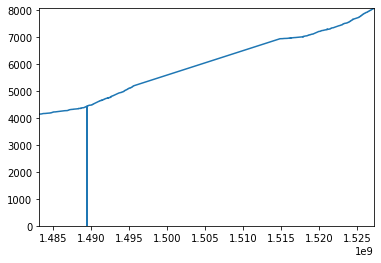

In [ ]:
X = raw_energy["seconds"]
Y = raw_energy["total_solar_production"]
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])

[0, 32833, 981.0, 1041.5]

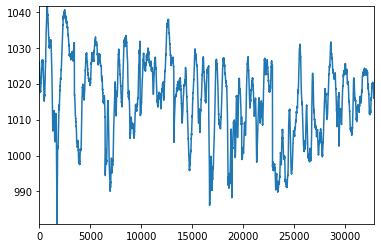

In [ ]:
# TODO: explore the values in different columns (experiment with different visualizations, e.g. line, histogram, ...)
X = raw_weather.index
Y = raw_weather['air pressure']
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])

[0, 32833, 25.0, 100.0]

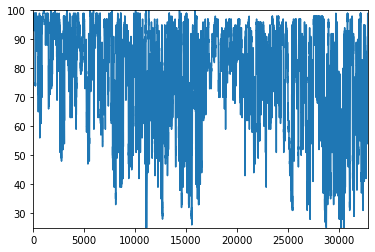

In [ ]:
X = raw_weather.index
Y = raw_weather['humidity']
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])

[0, 32833, -8.3, 30.6]

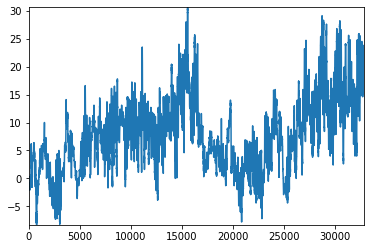

In [ ]:
X = raw_weather.index
Y = raw_weather['temperature']
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])

[0, 32833, 44.0, 49900.0]

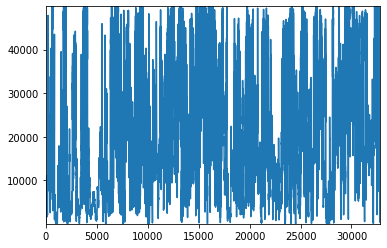

In [ ]:
X = raw_weather.index
Y = raw_weather['visibility']
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])

[0, 32833, 'N', 'ZZW']

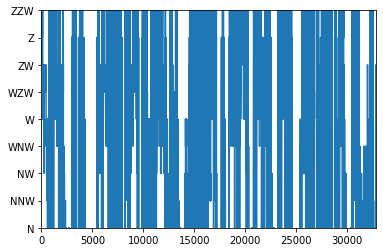

In [ ]:
X = raw_weather.index
Y = raw_weather['wind direction']
plt.plot(X, Y)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])

### Question 1

Simple visual inspection of the data can already tell you a lot about what you are working with. The data covers all of 2017 and 2018, because the data was split into training and test sets, some time ranges will be missing. Assign to `question_missing_months` below the numbers of the months that are missing from the training set (1 for January, 2 for February, ..., 12 for December). You will probably have to convert UTC timestamps.

In [ ]:
#// BEGIN_TODO [Q1]
#// END_TODO [Q1]

In [ ]:
q1_raw_energy = raw_energy.copy()
q1_raw_weather = raw_weather.copy()

In [ ]:
# raw_energy has a date column, so that's easier
# raw_weather has a time column, so that's not actually harder

energy_months = q1_raw_energy['date'].str.split("-", expand=True)[1].array
print(energy_months.unique())

weather_months = q1_raw_weather['time'].str.split("-", expand=True)[1].array
print(weather_months.unique())

<PandasArray>
['01', '02', '03', nan, '04', '05']
Length: 6, dtype: object
<PandasArray>
['01', '02', '03', '04', '05']
Length: 5, dtype: object


In [ ]:
# dropna() is needed because of the presence of a nan value in the energy months
final_energy_months = energy_months.unique().dropna().astype('int32')
final_weather_months = weather_months.unique().dropna().astype('int32')
print(final_energy_months)
print(final_weather_months)
# Since both are identical, one of them is assigned to question_missing_months 
question_current_months = final_energy_months.copy()
question_missing_months = [6,7,8,9,10,11,12]
print('The months in the training data are - ', question_missing_months)

[1 2 3 4 5]
[1 2 3 4 5]
The months in the training data are -  [6, 7, 8, 9, 10, 11, 12]


### Clean the data

Data cleaning is an important part of any data analysis task. According to the general wisdom, most effort actually is spent on data cleaning. It involves preparing the data for the following steps, e.g. converting values to the right type, filling in missing values, removing outliers, normalizing the data, etc.

In the plot above you will have noticed vertical lines. These lines correspond to 0 values and are likely to be measuring errors (e.g. the solar panel meter has crashed). Such outliers will often negatively impact the accuracy of the predictive model. However, care must be taken to properly define what constitutes an outlier and what constitutes a valid measurement. Some odd looking measurements may actually contain important evidence for proving or disproving a hypothesis. In this case the 0 values can be considered measurement errors and should be removed.

Pandas provides convenient methods for selecting subsets of the data that can be used for removing outliers:

- https://jakevdp.github.io/PythonDataScienceHandbook/03.02-data-indexing-and-selection.html

In [ ]:
# TODO: remove the samples with production total of 0
clean_raw_energy = raw_energy.copy()
clean_raw_weather = raw_weather.copy()

In [ ]:
# Also removing NaN values, seemed required
print(clean_raw_energy)
# print(clean_raw_energy['total_solar_production'].isna().value_counts())
# print(clean_raw_energy[clean_raw_energy['total_solar_production'] == 0])
# print(clean_raw_energy[clean_raw_energy['total_solar_production'].isna()])
clean_raw_energy = clean_raw_energy[clean_raw_energy['total_solar_production'] != 0]
clean_raw_energy = clean_raw_energy[~clean_raw_energy['total_solar_production'].isna()]
print(clean_raw_energy)

               date       time     seconds  total_consumption  \
0        2017-01-01   01:00:01  1483228801          13188.301   
1        2017-01-01   01:00:11  1483228811          13188.302   
2        2017-01-01   01:00:21  1483228821          13188.304   
3        2017-01-01   01:00:31  1483228831          13188.305   
4        2017-01-01   01:00:41  1483228841          13188.307   
...             ...        ...         ...                ...   
1987359  2018-05-25   01:59:23  1527206363          18343.591   
1987360  2018-05-25   01:59:33  1527206373          18343.591   
1987361  2018-05-25   01:59:43  1527206383          18343.592   
1987362  2018-05-25   01:59:43  1527206383          18343.592   
1987363  2018-05-25   01:59:53  1527206393          18343.593   

         total_production solar_production  total_solar_production  year  
0                4499.785                0                  4147.1  2017  
1                4499.785                0                  4147.1  2

Data that is collected in the wild will sometimes contain formatting inconsistencies. It is a good habit to check the data types:

In [ ]:
raw_energy.dtypes

date                       object
time                       object
seconds                     int64
total_consumption         float64
total_production          float64
solar_production           object
total_solar_production    float64
year                        int64
dtype: object

As expected, the `'total_consumption'`, `'total_production'`, `'total_solar_production'` columns are of numerical type, however, the `solar_production` is of an `object` type (which is also used for strings), while looking at the specification of the column above we would expect a numerical type. Modeling this column later will require a numerical column, so it will need to be converted to the right type first.

In [ ]:
# TODO: explore the offending values in the solar_production column
print(raw_energy['solar_production'].value_counts())
print(raw_energy[raw_energy['solar_production']==''])

# Exploration shows that the strings are mainly differing through leading and trailing 
# spaces. These are fixed through direct conversion.

0        881564
0        163532
 0        21338
72         8520
9          7907
          ...  
2782         21
 1119        21
 972         14
 1296         7
1301          6
Name: solar_production, Length: 4425, dtype: int64
Empty DataFrame
Columns: [date, time, seconds, total_consumption, total_production, solar_production, total_solar_production, year]
Index: []


### Question 2

Convert empty strings in the `'solar_production'` column to `np.nan`.

In [ ]:
#// BEGIN_TODO [Q2]
#// END_TODO [Q2]

In [ ]:
# print(q2_energy['solar_production'])
print(clean_raw_energy[clean_raw_energy['solar_production']== ''])
# 0 cells with empty spaces

Empty DataFrame
Columns: [date, time, seconds, total_consumption, total_production, solar_production, total_solar_production, year]
Index: []


In [ ]:
# There's no empty strings in solar production

### Question 3

Convert the remaining values in the `'solar_production'` column to `float` type.

In [ ]:
#// BEGIN_TODO [Q3]
clean_raw_energy = clean_raw_energy.astype({'solar_production': 'float64'})

print(clean_raw_energy['solar_production'].value_counts())
# The example of 0 from the previous cell shows that this has worked.
# 881564 + 163532 + 21338 = 1066434

#// END_TODO [Q3]

0.0       1066434
9.0         10141
56.0         9643
72.0         9591
57.0         8380
           ...   
2855.0         28
2846.0         28
2365.0         28
2761.0         28
2782.0         21
Name: solar_production, Length: 2705, dtype: int64


### Engineer features

The goal of this assignment is to predict the hourly energy output of the solar panels given the weather forecast. This requires to relate the energy samples with the weather samples, basically attaching the energy production label to the weather measurements. However, the *total* energy and weather samples are taken approximately every 10 seconds and 10 minutes, respectively.

####  Aggregate per hour

We can use pandas grouping functions to aggregate the samples per hour, taking the largest  measurement in that hour.

In [ ]:
col = "total_solar_production"
energy = raw_energy.copy()
times = pd.to_datetime(energy["seconds"], unit='s')

energy = energy.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])[[col]].agg(np.max)
energy.index.names = ["year", "month", "day", "hour"]

In [ ]:
print(energy)
print(energy.dtypes)
print(energy.columns)

                     total_solar_production
year month day hour                        
2017 1     1   0                     4147.1
               1                     4147.1
               2                     4147.1
               3                     4147.1
               4                     4147.1
...                                     ...
2018 5     144 19                    8069.1
               20                    8069.1
               21                    8078.8
               22                    8078.8
               23                    8078.8

[5528 rows x 1 columns]
total_solar_production    float64
dtype: object
Index(['total_solar_production'], dtype='object')


In [ ]:
# Testing

temp_col = "total_solar_production"
temp_energy = clean_raw_energy.copy()
times = pd.to_datetime(temp_energy["seconds"], unit='s')

temp_energy = temp_energy.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])[[temp_col]].agg(np.max)
temp_energy.index.names = ["year", "month", "day", "hour"]


In [ ]:
print(temp_energy)
print(temp_energy.dtypes)
print(temp_energy.columns)

                     total_solar_production
year month day hour                        
2017 1     1   0                     4147.1
               1                     4147.1
               2                     4147.1
               3                     4147.1
               4                     4147.1
...                                     ...
2018 5     144 19                    8069.1
               20                    8069.1
               21                    8078.8
               22                    8078.8
               23                    8078.8

[5528 rows x 1 columns]
total_solar_production    float64
dtype: object
Index(['total_solar_production'], dtype='object')


In [ ]:
temp_energy["production"] = temp_energy[col] - temp_energy[col].shift(1)

In [ ]:
print(temp_energy)
print(temp_energy['production'].value_counts())
print(temp_energy[temp_energy['production'].isna()])

                     total_solar_production  production
year month day hour                                    
2017 1     1   0                     4147.1         NaN
               1                     4147.1         0.0
               2                     4147.1         0.0
               3                     4147.1         0.0
               4                     4147.1         0.0
...                                     ...         ...
2018 5     144 19                    8069.1         0.0
               20                    8069.1         0.0
               21                    8078.8         9.7
               22                    8078.8         0.0
               23                    8078.8         0.0

[5528 rows x 2 columns]
0.0     3247
0.1      334
0.1      228
0.2      194
0.3      149
        ... 
3.8        1
84.2       1
4.2        1
64.3       1
52.7       1
Name: production, Length: 72, dtype: int64
                     total_solar_production  production
year 

### Question 4 ###

Note that the hourly aggregation using the maximum works well for columns containing the totals. Does it also work for the `'solar_production'` column?

1. Yes, but the aggregation method needs to be changed to fit the solar_production data type
2. Yes, the same aggregation method can be applied
3. No, it's not possible to aggegrate over the solar_production field
4. No, aggregating over the solar_production field in any way does not make sense.
5. None of the above.

Assign an integer corresponding to the correct answer to variable `question_aggregation`.

In [ ]:
#// BEGIN_TODO [Q4]
question_aggregation = 2
# Aggregation is possible on the data since we converted it to float64.
# It could also be considered to perform average or sum instead of maximum, since 
# that might give a more realistic estimate of hourly solar production

#// END_TODO [Q4]

After aggregation, some cells can contain `Nan` values (e.g. when trying to compute a maximum for an hour during which no samples were recorded). Therefore, after performing such operations one should decide what to do with any NaN values. In this case we chose to remove such samples.

In [ ]:
print(energy)
energy = energy.dropna()
print(energy)

                     total_solar_production
year month day hour                        
2017 1     1   0                     4147.1
               1                     4147.1
               2                     4147.1
               3                     4147.1
               4                     4147.1
...                                     ...
2018 5     144 19                    8069.1
               20                    8069.1
               21                    8078.8
               22                    8078.8
               23                    8078.8

[5528 rows x 1 columns]
                     total_solar_production
year month day hour                        
2017 1     1   0                     4147.1
               1                     4147.1
               2                     4147.1
               3                     4147.1
               4                     4147.1
...                                     ...
2018 5     144 19                    8069.1
       

After grouping, merging and slicing operations, the index of a data frame might need to be recomputed, to reflect the new ordering of rows.

In [ ]:
energy = energy.reset_index()

In [ ]:
print(energy)

      year  month  day  hour  total_solar_production
0     2017      1    1     0                  4147.1
1     2017      1    1     1                  4147.1
2     2017      1    1     2                  4147.1
3     2017      1    1     3                  4147.1
4     2017      1    1     4                  4147.1
...    ...    ...  ...   ...                     ...
5523  2018      5  144    19                  8069.1
5524  2018      5  144    20                  8069.1
5525  2018      5  144    21                  8078.8
5526  2018      5  144    22                  8078.8
5527  2018      5  144    23                  8078.8

[5528 rows x 5 columns]


#### Compute the hourly production

We are interested in predicting the solar panel output in a given hour. However, the `'total_solar_production'` column in the energy data frame at this point contains the total solar panel output until the end of that hour. Assuming that the data set contains a sample for every hour, i.e. there are no gaps, the hourly output can be compouted by taking the difference between the previous sample.

In [ ]:
energy["production"] = energy[col] - energy[col].shift(1)

In [ ]:
print(energy)
print(energy['production'].value_counts())
print(energy[energy['production'].isna()])

      year  month  day  hour  total_solar_production  production
0     2017      1    1     0                  4147.1         NaN
1     2017      1    1     1                  4147.1         0.0
2     2017      1    1     2                  4147.1         0.0
3     2017      1    1     3                  4147.1         0.0
4     2017      1    1     4                  4147.1         0.0
...    ...    ...  ...   ...                     ...         ...
5523  2018      5  144    19                  8069.1         0.0
5524  2018      5  144    20                  8069.1         0.0
5525  2018      5  144    21                  8078.8         9.7
5526  2018      5  144    22                  8078.8         0.0
5527  2018      5  144    23                  8078.8         0.0

[5528 rows x 6 columns]
0.0     3247
0.1      334
0.1      228
0.2      194
0.3      149
        ... 
3.8        1
84.2       1
4.2        1
64.3       1
52.7       1
Name: production, Length: 72, dtype: int64
   year  

In [ ]:
# energy = energy.dropna().reset_index()
energy.head()

,year,month,day,hour,total_solar_production,production
0,2017,1,1,0,4147.1,NaN
1,2017,1,1,1,4147.1,0.0
2,2017,1,1,2,4147.1,0.0
3,2017,1,1,3,4147.1,0.0
4,2017,1,1,4,4147.1,0.0


### Question 5 ###

After creating the production column there are NaNs in the data. Where do they come from, and why is the index recomputed?

1. The NaN values are caused by missing values in the original data due to sensor errors, and the index is reset because a column has been added.
2. The NaN values are caused by missing values in the original data due to the way the column is calculated, and the index is reset because a column has been added.
3. The NaN values are caused by missing values in the original data due to sensor errors, and the index is reset because the number of rows has changed.
4. The NaN values are caused by missing values in the original data due to the way the column is calculated, and the index is reset because the number of rows has changed.

Assign an integer corresponding to the correct answer to variable `question_production`.

In [ ]:
#// BEGIN_TODO [Q5]
question_production = 4
#// END_TODO [Q5]
# There's just one NaN value, and it's because of how the values have been calculated. 
# You drop the first row, the number of rows changes.

Now we can perform a similar aggregation for the `clouds` column in the weather data. Note that rather than choosing the maximum, we take the average `clouds` value per hour.

In [ ]:
weather = raw_weather.copy()
times = pd.to_datetime(weather["time"])
weather = weather.groupby([times.dt.year, times.dt.month, times.dt.dayofyear, times.dt.hour])["clouds"].agg(np.mean)
weather.index.names = ["year", "month", "day", "hour"]
weather = weather.reset_index()

In [ ]:
print(weather)

      year  month  day  hour  clouds
0     2017      1    1     0     0.0
1     2017      1    1     1     0.0
2     2017      1    1     2     0.0
3     2017      1    1     3     0.0
4     2017      1    1     4     0.0
...    ...    ...  ...   ...     ...
5485  2018      5  144    19     0.0
5486  2018      5  144    20     0.0
5487  2018      5  144    21     0.0
5488  2018      5  144    22     0.0
5489  2018      5  144    23     0.0

[5490 rows x 5 columns]


#### Merge the data frames

Now that both data frames are expressed in terms of hours and the energy data frame contains the hourly solar panel output, we can use pandas to merge them.

**Important:** when dealing with times in data from various sources one must be very carefull about the semantics of the time, such as the time-zone or the daylight-saving. Luckily, in this assignment both energy and weather data use UTC time, so no extra preprocessing is required.

In [ ]:
data = pd.merge(energy, weather).dropna().reset_index(drop=True)
data.head()

,year,month,day,hour,total_solar_production,production,clouds
0,2017,1,1,1,4147.1,0.0,0.0
1,2017,1,1,2,4147.1,0.0,0.0
2,2017,1,1,3,4147.1,0.0,0.0
3,2017,1,1,4,4147.1,0.0,0.0
4,2017,1,1,5,4147.1,0.0,0.0


In [ ]:
q6_data = data.copy()

In [ ]:
print(q6_data['production'].value_counts())
# print(q6_data[q6_data['production'] > 2.8]['production'].value_counts())
print(q6_data[q6_data['production'] > 2.55]['production'].value_counts().sort_index())

0.0     3198
0.1      330
0.1      226
0.2      193
0.3      145
        ... 
9.7        1
3.7        1
84.2       1
11.6       1
52.7       1
Name: production, Length: 70, dtype: int64
2.6     2
2.7     1
3.0     1
3.1     1
3.7     1
3.7     1
3.8     1
4.2     1
4.5     1
5.7     1
6.5     1
7.4     1
9.7     1
10.6    2
11.6    1
14.2    1
14.3    1
17.3    1
23.6    1
26.5    1
52.7    1
64.3    1
84.2    1
87.4    1
Name: production, dtype: int64


In [ ]:
print(q6_data[q6_data['production'] > 10])
print(q6_data[(q6_data['day'] > 82) & (q6_data['day'] < 92) & (q6_data['year'] == 2017)])

      year  month  day  hour  total_solar_production  production    clouds
570   2017      2   32     0                  4255.0        23.6  1.000000
1063  2017      3   60     0                  4349.7        17.3  0.000000
1076  2017      3   60    13                  4360.3        10.6  0.000000
1167  2017      3   64     8                  4372.7        11.6  2.166667
1639  2017      4   91     0                  4622.9        87.4  2.666667
1731  2017      4   94    20                  4661.6        10.6  0.166667
2087  2017      4  109    16                  4798.3        26.5  1.500000
2191  2017      5  121     0                  4927.1        84.2  0.000000
3302  2018      2   32     0                  7008.5        14.2  3.000000
4345  2018      4   91     0                  7433.0        64.3  0.000000
4870  2018      4  112    21                  7681.1        14.3  0.000000
4873  2018      5  121     0                  7733.8        52.7  0.000000
      year  month  day  h

#### Explore the engineered features

After engineering features it is a good idea to explore the data set again, to see if extra cleaning is required.

0.0 87.39999999999964


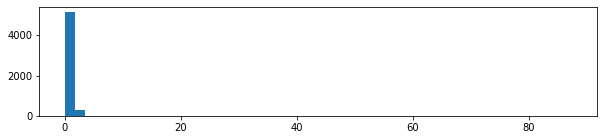

In [ ]:
values = data["production"].values
plt.figure(figsize=(10, 2))
plt.hist(values, 50);
print (min(values), max(values))

The small variance of the values and their large range suggests there are some outliers. This can be also visualized in a different way.

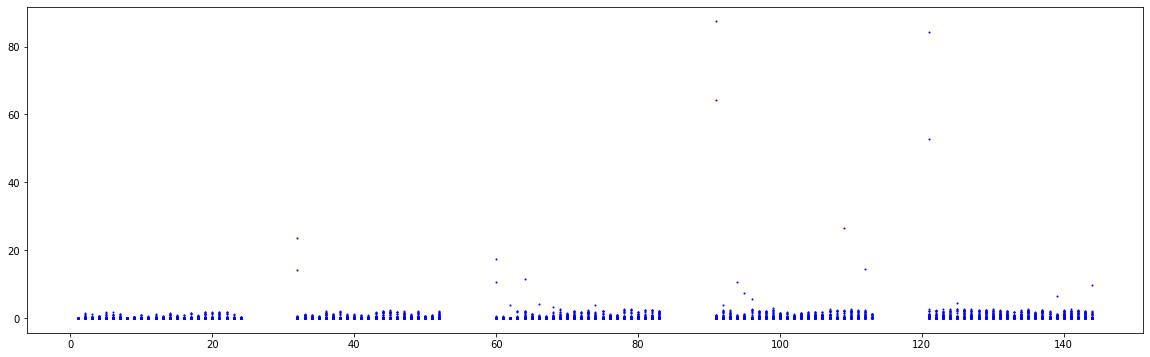

In [ ]:
def plot(df, col):
    x = df["day"]
    plt.figure(figsize=(20,6))
    plt.plot(x, df[col], 'bo', markersize=1)

plot(data, "production")

The figure suggests that there are indeed outliers in the energy production data.

### Question 6

The plot shows some outliers. How do you explain these? Choose all correct answers.

1. There is actually an oversight in the previous calculations which causes the outliers.
2. There is some unclean data present due to sensor errors.
3. There were some very clear and sunny days.
4. The outliers represent multiple days of production.

Assign a list of integers corresponding to the correct answers to variable `question_outliers`.

In [ ]:
#// BEGIN_TODO [Q6]
question_outliers = [1, 4]
#// END_TODO [Q6]

Note that when removing the energy samples containing 0 values in `raw_energy` earlier, it was clear how to define an outlier. In this case, however, one must carefully decide how to define an outlier, to avoid introducing bias. You can read more about outlier detection here:

- Section 3.3.3 of "Introduction to Statistical Learning"
- http://scikit-learn.org/stable/modules/outlier_detection.html

### Question 7

How do you best define an outlier for this data set?

1. Calculate the average production, and define an outlier based on standard deviations.
2. Build a model for the expected production, and label outliers based on the model predictions.
3. Set a fixed threshold for outliers based on the characteristics of the solar panels.
4. Estimate a fixed threshold for outliers by hand based on the above plot.

Assign an integer corresponding to the correct answer to variable `question_outlier_definition`.

In [ ]:
#// BEGIN_TODO [Q7]
question_outlier_definition = 3
#// END_TODO [Q7]

### Question 8

Remove the outliers from the `data` data frame. Assign the resulting data frame to variable `data_no_outliers`. 

In [ ]:
q8_data = data.copy()

      year  month  day  hour  total_solar_production  production  clouds
0     2017      1    1     1                  4147.1         0.0     0.0
1     2017      1    1     2                  4147.1         0.0     0.0
2     2017      1    1     3                  4147.1         0.0     0.0
3     2017      1    1     4                  4147.1         0.0     0.0
4     2017      1    1     5                  4147.1         0.0     0.0
...    ...    ...  ...   ...                     ...         ...     ...
5444  2018      5  144    19                  8069.1         0.0     0.0
5445  2018      5  144    20                  8069.1         0.0     0.0
5446  2018      5  144    21                  8078.8         9.7     0.0
5447  2018      5  144    22                  8078.8         0.0     0.0
5448  2018      5  144    23                  8078.8         0.0     0.0

[5449 rows x 7 columns]


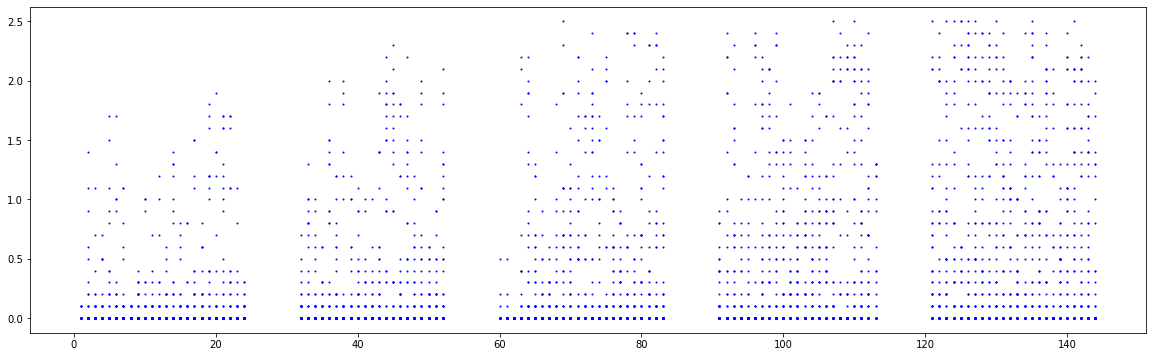

In [ ]:
print(q8_data)
q8_data = q8_data[q8_data['production'] < 2.55]
# data_temp_production = q8_data['production']
# print(data_temp_production.mean())
# print(data_temp_production.var())
# print(data_temp_production.std())
# print(q6_data[q6_data['production'] > 2.55]['production'].value_counts().sort_index())
# print(q8_data)
plot(q8_data, "production")

In [ ]:
#// BEGIN_TODO [Q8]
data_no_outliers = q8_data.copy()
#// END_TODO [Q8]

Data visualization is often helpful to check if the results of our data processing and analysis meet our expectations.

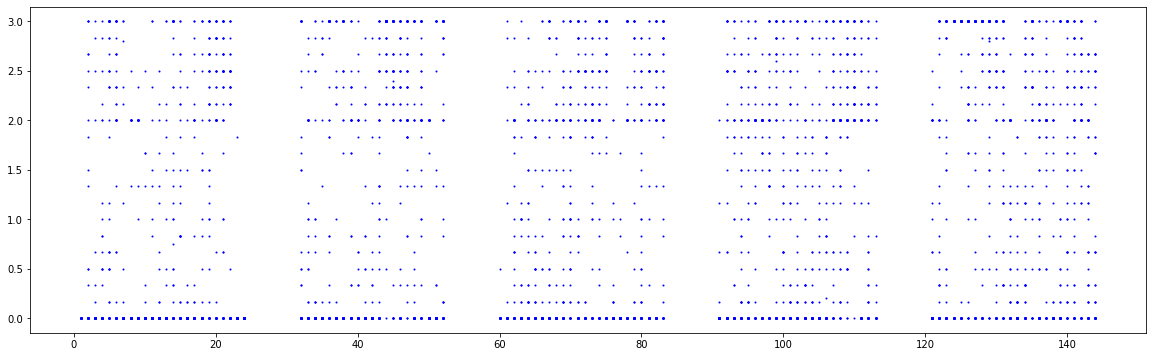

In [ ]:
# TODO: plot the clouds feature
plot(q8_data, "clouds")

In [ ]:
print(data_no_outliers.columns)
print(data.columns)

Index(['year', 'month', 'day', 'hour', 'total_solar_production', 'production',
       'clouds'],
      dtype='object')
Index(['year', 'month', 'day', 'hour', 'total_solar_production', 'production',
       'clouds'],
      dtype='object')


### Train a model

For training and evaluating the perfromance of a model we need to split the data into a training and a test.

In [ ]:
train_data = data_no_outliers.copy()

In [ ]:
X = train_data[["clouds"]].values
y = train_data["production"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Evaluate the model

After a model is trained we would like to estimate how well it is performing, whether we can actually trust its predictions if it were deployed. Model performance can be estimated using various visualisations and statistics (see Section 3.1.3 of [ISLR])

#### Model fit

If the feature space is 1 or 2 dimensional, then we can easily plot the model to illustrate how well it fits the test data.

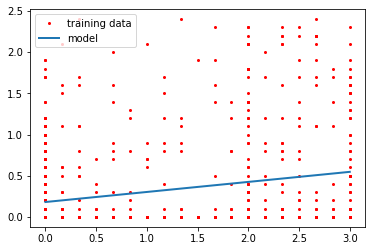

In [ ]:
x_plot = np.linspace(min(X), max(X), 100)
X_plot = x_plot.reshape(-1, 1)
y_plot = model.predict(X_plot)

dots, = plt.plot(X_test, y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(x_plot, y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line]);

We can compute the R2 score to assign a number to how well the model fits the data. It estimates how much of the variance in the data is explained by the model, i.e. how well the model fits the data. A score of 1 means the model captures all of the variance, and a score of 0 means the model does not capture any of the variance.

You can read more about the R2 score in Section 3.1.3 of "Introduction to Statistical Learning".

In [ ]:
model.score(X_test, y_test)

0.025607651535383358

#### Residuals

We can also plot a histogram of the residuals (or errors), i.e. the deviations of the values predicted by our model from the ground truth values (from the test set):

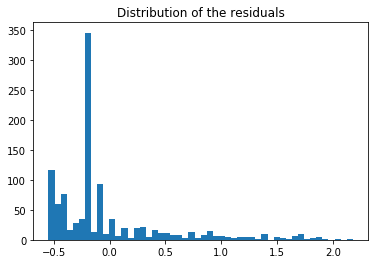

In [ ]:
y_pred = model.predict(X_test)
plt.title("Distribution of the residuals")
plt.hist(y_test - y_pred, 50);

Looking at the histogram you will notice that distribution of the residuals is not symmetric.

### Question 9

Does the model tend to over-estimate, or under-estimate the solar panel output?

1. The model tends to over-estimate.
2. The model tends to under-estimate.
3. The model is not biased

Assign an integer corresponding to the correct answer to variable `question_bias`. 

In [ ]:
#// BEGIN_TODO [Q9]
question_bias = 2
#// END_TODO [Q9]

If the model is not biased, or if we are not interested in the bias, then we can compute the mean absolute deviation (MAD) to estimate the expected error of a prediction. E.g. a MAD = 0.345 means that we expect on average our predition to be off by 0.345kWh.

In [ ]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.3834030597203876

### Improve the model

We have shown here a simple linear model mapping the `clouds` feature to the `hourly_production` label. However, this model does not perform very well. The problem could be that the model is underfitting or overfitting the data. You can find more about under- and overfitting in Section 2.1.2, 2.1.3, 6.1 of "Introduction to Statistical Learning", 7th edition.

### Question 10 ###

Is the model underfitting or overfitting the training data? What makes you say that?

1. The model is underfitting. This can be seen by the straightness of the line of the model in the plot.
2. The model is underfitting. This can be seen by the location of the line of the model in the plot.
3. The model is overfitting. This can be seen by the straightness of the  line of the model in the plot.
4. The model is overfitting. This can be seen by the location of the line of the model in the plot.

Assign an integer corresponding to the correct answer to variable `question_fitting`. 

In [ ]:
#// BEGIN_TODO [Q10]
question_fitting = 1
# A linear model couldn't possibly identify an entire trend in the data. There must be other factors influencing as well.
# Time of day, month of year.
#// END_TODO [Q10]

One could try several things to improve the model.

#### Add more features

The simple linear model assumed that there is a strong relation ship between the clouds (or their absence) and the output of the solar panels. However, clouds alone are not a sufficient indicator, e.g. during the night. You may plot a histogram showing how the `clouds` values are distributed during the 24 hours of a day:

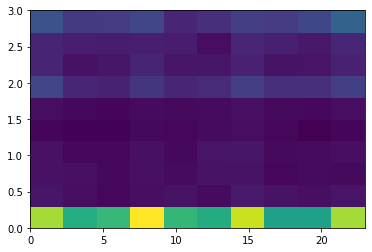

In [ ]:
plt.hist2d(weather.dropna().hour.values, weather.dropna().clouds.values);

### Question 11

Why is the `clouds` column alone not a good indicator for the solar panel output?

Answer this question in max. 50 words and assign your string answer to the variable `question_clouds`.

In [ ]:
#// BEGIN_TODO [Q11]
question_clouds = '''
Production itself could depend on multiple factors, heat intensity, sunlight hours, effectiveness of solar panels. 
There might be overcast days with high production, or clear days with low sunlight and low production.
Temperature itself varies over a range of -8 to 30 degrees over the 5 months.
'''
#// END_TODO [Q11]

While the `clouds` column alone may not be sufficient for predicting the solar planel output, it can be used in combination with other features. Therefore, one way of improving the simple linear model could be to extend it with more features. You can gain insight into which features could be relevant by plotting the relationship between the features and the labels.

In [ ]:
# TODO: use the scatter matrix graph to explore the relationship between the features
def plot_2d(df, colx, coly):
    x = df[colx]
    plt.figure(figsize=(20,6))
    plt.plot(x, df[coly], 'bo', markersize=1)

In [ ]:
q12_weather = raw_weather.copy()
q12_times = pd.to_datetime(q12_weather["time"])

In [ ]:
ap_weather = q12_weather.groupby([q12_times.dt.year, q12_times.dt.month, q12_times.dt.dayofyear, q12_times.dt.hour])["air pressure"].agg(np.mean)
ap_weather.index.names = ["year", "month", "day", "hour"]
ap_weather = ap_weather.reset_index()

In [ ]:
ap_data = pd.merge(energy, ap_weather).dropna().reset_index(drop=True)
ap_data = ap_data[ap_data['production'] < 2.55]
print(ap_data)
# q8_data = q8_data[q8_data['production'] < 2.55]

      year  month  day  hour  total_solar_production  production  air pressure
0     2017      1    1     1                  4147.1         0.0   1024.650000
1     2017      1    1     2                  4147.1         0.0   1024.066667
2     2017      1    1     3                  4147.1         0.0   1023.166667
3     2017      1    1     4                  4147.1         0.0   1022.266667
4     2017      1    1     5                  4147.1         0.0   1021.616667
...    ...    ...  ...   ...                     ...         ...           ...
5443  2018      5  144    18                  8069.1         0.0   1016.433333
5444  2018      5  144    19                  8069.1         0.0   1016.783333
5445  2018      5  144    20                  8069.1         0.0   1016.983333
5447  2018      5  144    22                  8078.8         0.0   1017.016667
5448  2018      5  144    23                  8078.8         0.0   1017.100000

[5423 rows x 7 columns]


In [ ]:
vi_weather = q12_weather.groupby([q12_times.dt.year, q12_times.dt.month, q12_times.dt.dayofyear, q12_times.dt.hour])["visibility"].agg(np.mean)
vi_weather.index.names = ["year", "month", "day", "hour"]
vi_weather = vi_weather.reset_index()

In [ ]:
vi_data = pd.merge(energy, vi_weather).dropna().reset_index(drop=True)
vi_data = vi_data[vi_data['production'] < 2.55]
print(vi_data)

      year  month  day  hour  total_solar_production  production    visibility
0     2017      1    1     1                  4147.1         0.0    392.500000
1     2017      1    1     2                  4147.1         0.0    332.333333
2     2017      1    1     3                  4147.1         0.0    511.500000
3     2017      1    1     4                  4147.1         0.0   1758.333333
4     2017      1    1     5                  4147.1         0.0   2483.333333
...    ...    ...  ...   ...                     ...         ...           ...
5443  2018      5  144    18                  8069.1         0.0  31833.333333
5444  2018      5  144    19                  8069.1         0.0  17398.333333
5445  2018      5  144    20                  8069.1         0.0   9730.000000
5447  2018      5  144    22                  8078.8         0.0   8290.000000
5448  2018      5  144    23                  8078.8         0.0   9326.666667

[5423 rows x 7 columns]


In [ ]:
te_weather = q12_weather.groupby([q12_times.dt.year, q12_times.dt.month, q12_times.dt.dayofyear, q12_times.dt.hour])["temperature"].agg(np.mean)
te_weather.index.names = ["year", "month", "day", "hour"]
te_weather = te_weather.reset_index()

In [ ]:
te_data = pd.merge(energy, te_weather).dropna().reset_index(drop=True)
te_data = te_data[te_data['production'] < 2.55]
print(te_data)

      year  month  day  hour  total_solar_production  production  temperature
0     2017      1    1     1                  4147.1         0.0    -1.416667
1     2017      1    1     2                  4147.1         0.0    -1.300000
2     2017      1    1     3                  4147.1         0.0    -1.216667
3     2017      1    1     4                  4147.1         0.0    -1.216667
4     2017      1    1     5                  4147.1         0.0    -1.316667
...    ...    ...  ...   ...                     ...         ...          ...
5443  2018      5  144    18                  8069.1         0.0    20.866667
5444  2018      5  144    19                  8069.1         0.0    19.250000
5445  2018      5  144    20                  8069.1         0.0    17.433333
5447  2018      5  144    22                  8078.8         0.0    17.433333
5448  2018      5  144    23                  8078.8         0.0    17.000000

[5423 rows x 7 columns]


In [ ]:
hu_weather = q12_weather.groupby([q12_times.dt.year, q12_times.dt.month, q12_times.dt.dayofyear, q12_times.dt.hour])["humidity"].agg(np.mean)
hu_weather.index.names = ["year", "month", "day", "hour"]
hu_weather = hu_weather.reset_index()

In [ ]:
hu_data = pd.merge(energy, hu_weather).dropna().reset_index(drop=True)
hu_data = hu_data[hu_data['production'] < 2.55]
print(hu_data)

      year  month  day  hour  total_solar_production  production   humidity
0     2017      1    1     1                  4147.1         0.0  99.000000
1     2017      1    1     2                  4147.1         0.0  99.000000
2     2017      1    1     3                  4147.1         0.0  99.000000
3     2017      1    1     4                  4147.1         0.0  99.000000
4     2017      1    1     5                  4147.1         0.0  99.000000
...    ...    ...  ...   ...                     ...         ...        ...
5443  2018      5  144    18                  8069.1         0.0  68.333333
5444  2018      5  144    19                  8069.1         0.0  79.333333
5445  2018      5  144    20                  8069.1         0.0  93.000000
5447  2018      5  144    22                  8078.8         0.0  91.166667
5448  2018      5  144    23                  8078.8         0.0  93.666667

[5423 rows x 7 columns]


In [ ]:
ws_weather = q12_weather.groupby([q12_times.dt.year, q12_times.dt.month, q12_times.dt.dayofyear, q12_times.dt.hour])["wind speed"].agg(np.mean)
ws_weather.index.names = ["year", "month", "day", "hour"]
ws_weather = ws_weather.reset_index()

In [ ]:
ws_data = pd.merge(energy, ws_weather).dropna().reset_index(drop=True)
ws_data = ws_data[ws_data['production'] < 2.55]
print(ws_data)

      year  month  day  hour  total_solar_production  production  wind speed
0     2017      1    1     1                  4147.1         0.0    3.166667
1     2017      1    1     2                  4147.1         0.0    4.000000
2     2017      1    1     3                  4147.1         0.0    3.333333
3     2017      1    1     4                  4147.1         0.0    3.333333
4     2017      1    1     5                  4147.1         0.0    3.000000
...    ...    ...  ...   ...                     ...         ...         ...
5443  2018      5  144    18                  8069.1         0.0    4.166667
5444  2018      5  144    19                  8069.1         0.0    3.833333
5445  2018      5  144    20                  8069.1         0.0    1.500000
5447  2018      5  144    22                  8078.8         0.0    1.833333
5448  2018      5  144    23                  8078.8         0.0    1.333333

[5423 rows x 7 columns]


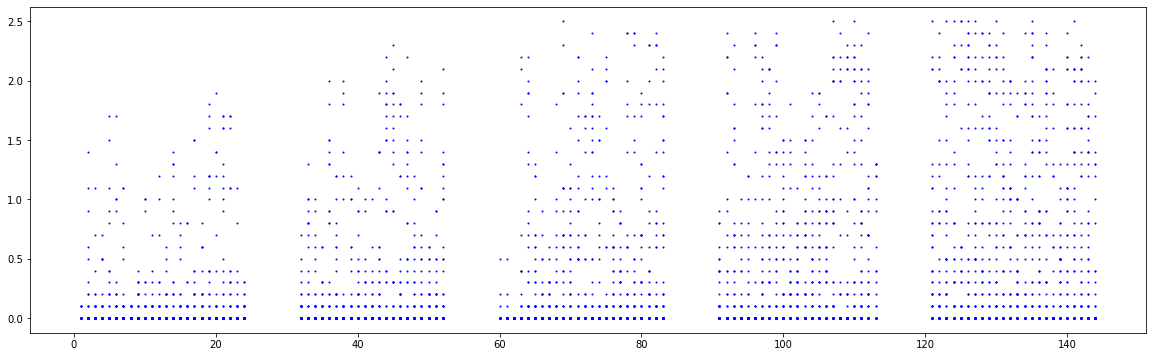

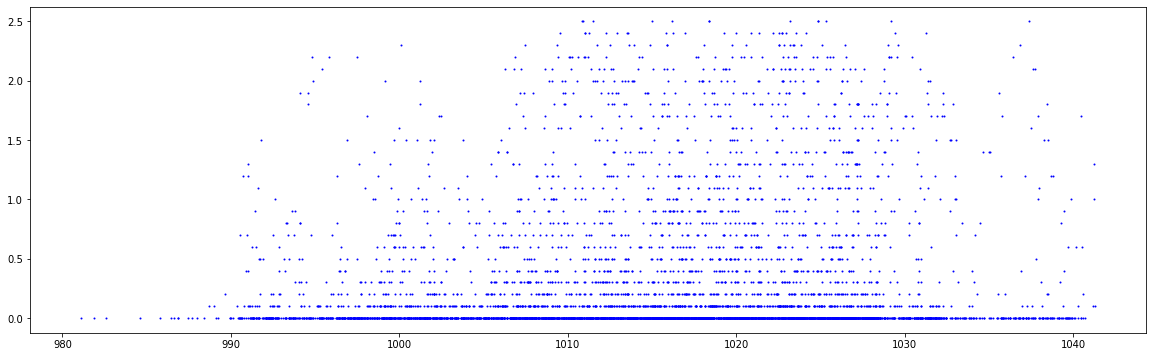

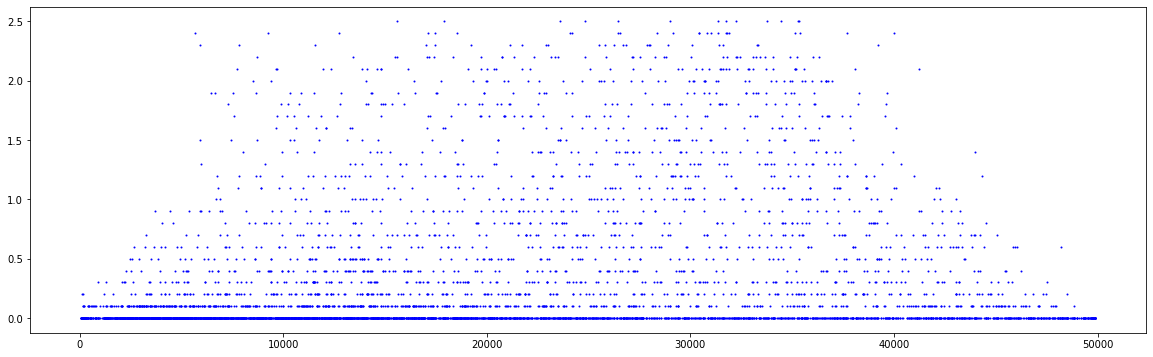

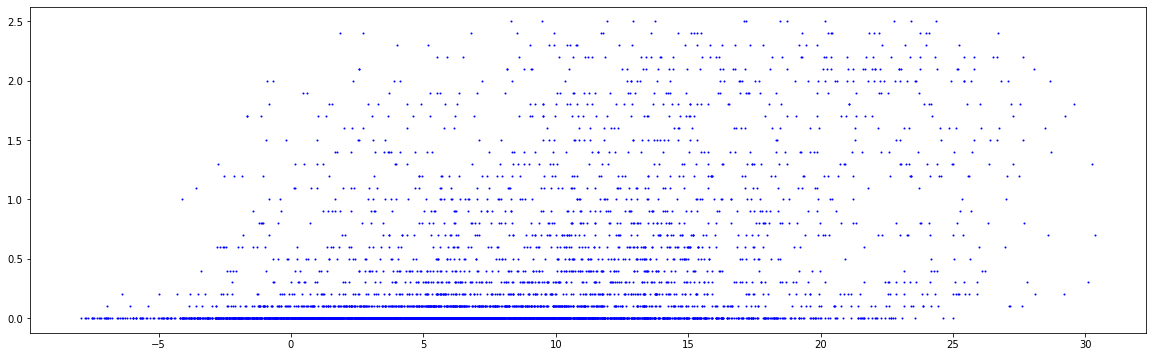

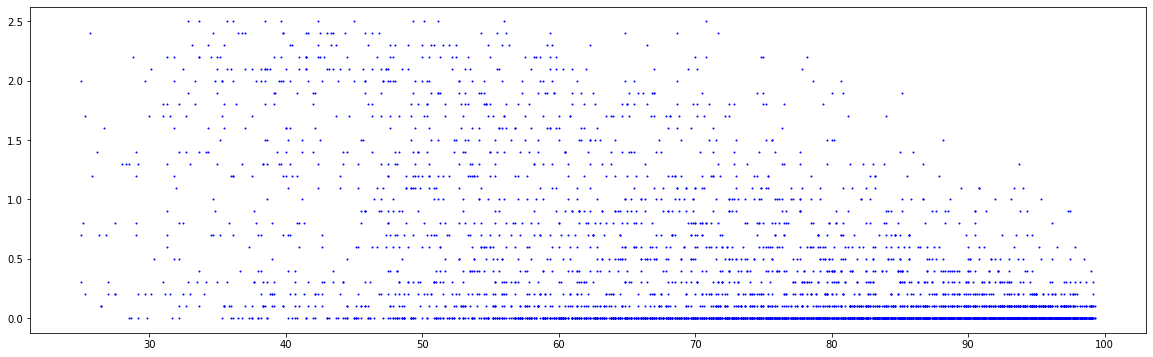

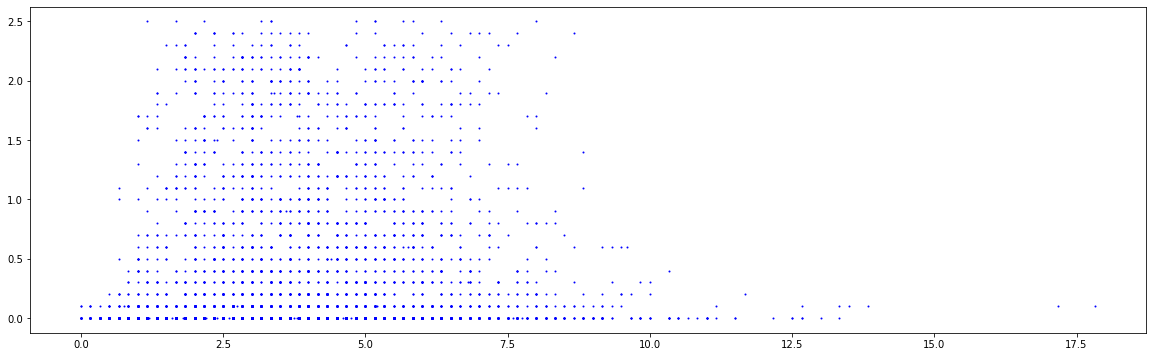

In [ ]:
plot_2d(data_no_outliers, "day", "production")
plot_2d(ap_data, "air pressure", "production")
plot_2d(vi_data, "visibility", "production")
plot_2d(te_data, "temperature", "production")
plot_2d(hu_data, "humidity", "production")
plot_2d(ws_data, "wind speed", "production")
# plot_2d(data_no_outliers, "production", "air pressure")
# plot_2d(data_no_outliers, "production", "humidity")
# all_combined = pd.merge(energy, hu_weather)


In [ ]:
all_combined = pd.merge(data_no_outliers, ap_data).dropna().reset_index(drop=True)
all_combined = pd.merge(all_combined, vi_data).dropna().reset_index(drop=True)
all_combined = pd.merge(all_combined, te_data).dropna().reset_index(drop=True)
all_combined = pd.merge(all_combined, hu_data).dropna().reset_index(drop=True)
all_combined = pd.merge(all_combined, ws_data).dropna().reset_index(drop=True)
print(all_combined)

      year  month  day  hour  total_solar_production  production  clouds  \
0     2017      1    1     1                  4147.1         0.0     0.0   
1     2017      1    1     2                  4147.1         0.0     0.0   
2     2017      1    1     3                  4147.1         0.0     0.0   
3     2017      1    1     4                  4147.1         0.0     0.0   
4     2017      1    1     5                  4147.1         0.0     0.0   
...    ...    ...  ...   ...                     ...         ...     ...   
5418  2018      5  144    18                  8069.1         0.0     0.0   
5419  2018      5  144    19                  8069.1         0.0     0.0   
5420  2018      5  144    20                  8069.1         0.0     0.0   
5421  2018      5  144    22                  8078.8         0.0     0.0   
5422  2018      5  144    23                  8078.8         0.0     0.0   

      air pressure    visibility  temperature   humidity  wind speed  
0      1024.6500

### Question 12 ###

Which features are most promising for predicting the solar panel output? Select two most promising features:

- `'year'`
- `'month'`
- `'day'`
- `'hour'`
- `'air pressure'`
- `'humidity'`
- `'visibility'`
- `'wind speed'`
- `'temperature'`

Assign a list of strings corresponding to the promising features to variable `question_features`.

In [ ]:
#// BEGIN_TODO [Q12]
question_features = ['temperature', 'humidity']
#// END_TODO [Q12]

Note that using additional features may require aggregating them per hour. The `clouds` feature was aggregated taking the maximum value within a given hour, but this may not be suitable for all features.

### Question 13 ###

Using your new-found knowledge of the features, re-define the data on which you train and evaluate your model. Try to improve your model as much as possible by only changing the selection of features.

Assign your new data, new model and the corresponding MAD score to the variables `improved_data`, `improved_model`, `improved_mad`, respectively.

In [ ]:
q13_data = all_combined.copy()
print(all_combined)

      year  month  day  hour  total_solar_production  production  clouds  \
0     2017      1    1     1                  4147.1         0.0     0.0   
1     2017      1    1     2                  4147.1         0.0     0.0   
2     2017      1    1     3                  4147.1         0.0     0.0   
3     2017      1    1     4                  4147.1         0.0     0.0   
4     2017      1    1     5                  4147.1         0.0     0.0   
...    ...    ...  ...   ...                     ...         ...     ...   
5418  2018      5  144    18                  8069.1         0.0     0.0   
5419  2018      5  144    19                  8069.1         0.0     0.0   
5420  2018      5  144    20                  8069.1         0.0     0.0   
5421  2018      5  144    22                  8078.8         0.0     0.0   
5422  2018      5  144    23                  8078.8         0.0     0.0   

      air pressure    visibility  temperature   humidity  wind speed  
0      1024.6500

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score = 0.025607651535383358
MAD = 0.3834030597203876


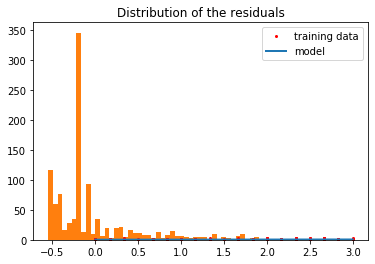

In [ ]:
q13_x = q13_data[["clouds"]].values
q13_y = q13_data["production"].values
q13_x_train, q13_x_test, q13_y_train, q13_y_test = train_test_split(q13_x, q13_y, test_size=0.2, random_state=42)

q13_model = LinearRegression()
print(q13_model.fit(q13_x_train, q13_y_train))

q13_x_plot = np.linspace(min(q13_x), max(q13_x), 100)
q13_x_plot = q13_x_plot.reshape(-1, 1)
q13_y_plot = q13_model.predict(q13_x_plot)

dots, = plt.plot(q13_x_test, q13_y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(q13_x_plot, q13_y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line])

print('Score =', q13_model.score(q13_x_test, q13_y_test))

q13_y_pred = q13_model.predict(q13_x_test)
plt.title("Distribution of the residuals")
plt.hist(q13_y_test - q13_y_pred, 50)

# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q13_y_test, q13_y_pred))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score = 0.1888831966415654
MAD = 0.33495365664418175


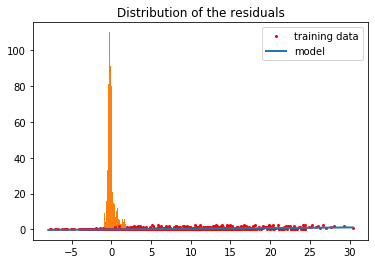

In [ ]:
q13_x = q13_data[["temperature"]].values
q13_y = q13_data["production"].values
q13_x_train, q13_x_test, q13_y_train, q13_y_test = train_test_split(q13_x, q13_y, test_size=0.2, random_state=42)

q13_model = LinearRegression()
print(q13_model.fit(q13_x_train, q13_y_train))

q13_x_plot = np.linspace(min(q13_x), max(q13_x), 100)
q13_x_plot = q13_x_plot.reshape(-1, 1)
q13_y_plot = q13_model.predict(q13_x_plot)

dots, = plt.plot(q13_x_test, q13_y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(q13_x_plot, q13_y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line])

print('Score =', q13_model.score(q13_x_test, q13_y_test))

q13_y_pred = q13_model.predict(q13_x_test)
plt.title("Distribution of the residuals")
plt.hist(q13_y_test - q13_y_pred, 50)

# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q13_y_test, q13_y_pred))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score = 0.02365816058812531
MAD = 0.3778254022335378


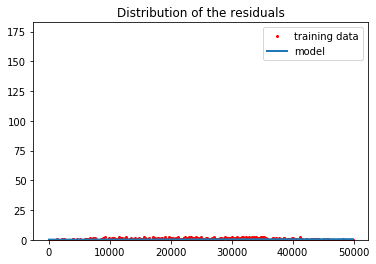

In [ ]:
q13_x = q13_data[["visibility"]].values
q13_y = q13_data["production"].values
q13_x_train, q13_x_test, q13_y_train, q13_y_test = train_test_split(q13_x, q13_y, test_size=0.2, random_state=42)

q13_model = LinearRegression()
print(q13_model.fit(q13_x_train, q13_y_train))

q13_x_plot = np.linspace(min(q13_x), max(q13_x), 100)
q13_x_plot = q13_x_plot.reshape(-1, 1)
q13_y_plot = q13_model.predict(q13_x_plot)

dots, = plt.plot(q13_x_test, q13_y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(q13_x_plot, q13_y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line])

print('Score =', q13_model.score(q13_x_test, q13_y_test))

q13_y_pred = q13_model.predict(q13_x_test)
plt.title("Distribution of the residuals")
plt.hist(q13_y_test - q13_y_pred, 50)

# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q13_y_test, q13_y_pred))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score = -0.009051261167933422
MAD = 0.3895379797370577


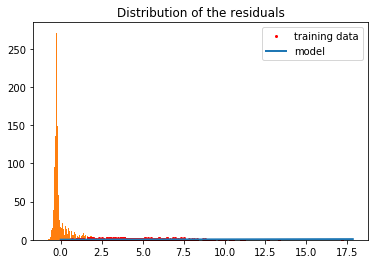

In [ ]:
q13_x = q13_data[["wind speed"]].values
q13_y = q13_data["production"].values
q13_x_train, q13_x_test, q13_y_train, q13_y_test = train_test_split(q13_x, q13_y, test_size=0.2, random_state=42)

q13_model = LinearRegression()
print(q13_model.fit(q13_x_train, q13_y_train))

q13_x_plot = np.linspace(min(q13_x), max(q13_x), 100)
q13_x_plot = q13_x_plot.reshape(-1, 1)
q13_y_plot = q13_model.predict(q13_x_plot)

dots, = plt.plot(q13_x_test, q13_y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(q13_x_plot, q13_y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line])

print('Score =', q13_model.score(q13_x_test, q13_y_test))

q13_y_pred = q13_model.predict(q13_x_test)
plt.title("Distribution of the residuals")
plt.hist(q13_y_test - q13_y_pred, 50)

# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q13_y_test, q13_y_pred))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score = 0.007846150585806955
MAD = 0.3880404077738483


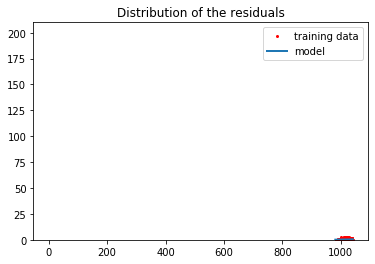

In [ ]:
q13_x = q13_data[["air pressure"]].values
q13_y = q13_data["production"].values
q13_x_train, q13_x_test, q13_y_train, q13_y_test = train_test_split(q13_x, q13_y, test_size=0.2, random_state=42)

q13_model = LinearRegression()
print(q13_model.fit(q13_x_train, q13_y_train))

q13_x_plot = np.linspace(min(q13_x), max(q13_x), 100)
q13_x_plot = q13_x_plot.reshape(-1, 1)
q13_y_plot = q13_model.predict(q13_x_plot)

dots, = plt.plot(q13_x_test, q13_y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(q13_x_plot, q13_y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line])

print('Score =', q13_model.score(q13_x_test, q13_y_test))

q13_y_pred = q13_model.predict(q13_x_test)
plt.title("Distribution of the residuals")
plt.hist(q13_y_test - q13_y_pred, 50)

# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q13_y_test, q13_y_pred))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score = 0.07162564191966003
MAD = 0.3621883198790055


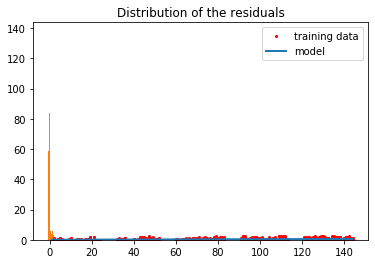

In [ ]:
q13_x = q13_data[["day"]].values
q13_y = q13_data["production"].values
q13_x_train, q13_x_test, q13_y_train, q13_y_test = train_test_split(q13_x, q13_y, test_size=0.2, random_state=42)

q13_model = LinearRegression()
print(q13_model.fit(q13_x_train, q13_y_train))

q13_x_plot = np.linspace(min(q13_x), max(q13_x), 100)
q13_x_plot = q13_x_plot.reshape(-1, 1)
q13_y_plot = q13_model.predict(q13_x_plot)

dots, = plt.plot(q13_x_test, q13_y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(q13_x_plot, q13_y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line])

print('Score =', q13_model.score(q13_x_test, q13_y_test))

q13_y_pred = q13_model.predict(q13_x_test)
plt.title("Distribution of the residuals")
plt.hist(q13_y_test - q13_y_pred, 50)

# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q13_y_test, q13_y_pred))


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score = -9.860150537477352e-05
MAD = 0.3896668587977614


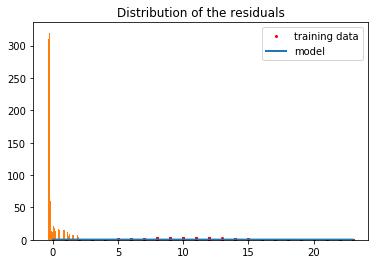

In [ ]:
q13_x = q13_data[["hour"]].values
q13_y = q13_data["production"].values
q13_x_train, q13_x_test, q13_y_train, q13_y_test = train_test_split(q13_x, q13_y, test_size=0.2, random_state=42)

q13_model = LinearRegression()
print(q13_model.fit(q13_x_train, q13_y_train))

q13_x_plot = np.linspace(min(q13_x), max(q13_x), 100)
q13_x_plot = q13_x_plot.reshape(-1, 1)
q13_y_plot = q13_model.predict(q13_x_plot)

dots, = plt.plot(q13_x_test, q13_y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(q13_x_plot, q13_y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line])

print('Score =', q13_model.score(q13_x_test, q13_y_test))

q13_y_pred = q13_model.predict(q13_x_test)
plt.title("Distribution of the residuals")
plt.hist(q13_y_test - q13_y_pred, 50)

# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q13_y_test, q13_y_pred))

# q13_humidity_model = q13_model
# q13_humidity_mad = mean_absolute_error(q13_y_test, q13_y_pred)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score = 0.266111557543255
MAD = 0.3152423607357361


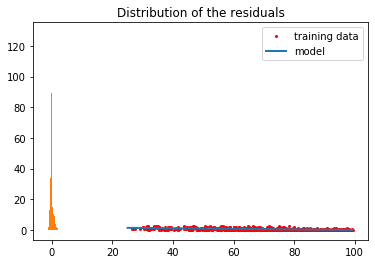

In [ ]:
q13_x = q13_data[["humidity"]].values
q13_y = q13_data["production"].values
q13_x_train, q13_x_test, q13_y_train, q13_y_test = train_test_split(q13_x, q13_y, test_size=0.2, random_state=42)

q13_model = LinearRegression()
print(q13_model.fit(q13_x_train, q13_y_train))

q13_x_plot = np.linspace(min(q13_x), max(q13_x), 100)
q13_x_plot = q13_x_plot.reshape(-1, 1)
q13_y_plot = q13_model.predict(q13_x_plot)

dots, = plt.plot(q13_x_test, q13_y_test, 'bo', markersize=2, color="red", label="training data");
line, = plt.plot(q13_x_plot, q13_y_plot, linewidth=2, label="model");
plt.legend(handles=[dots, line])

print('Score =', q13_model.score(q13_x_test, q13_y_test))

q13_y_pred = q13_model.predict(q13_x_test)
plt.title("Distribution of the residuals")
plt.hist(q13_y_test - q13_y_pred, 50)

# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q13_y_test, q13_y_pred))

q13_humidity_model = q13_model
q13_humidity_mad = mean_absolute_error(q13_y_test, q13_y_pred)

In [ ]:
#// BEGIN_TODO [Q13]
# Humidity proved to be the best performing feature selection, at least in my limited experimentation. 
improved_data = q13_data.copy()
improved_model = q13_humidity_model
improved_mad = q13_humidity_mad
#// END_TODO [Q13]

#### Choose a more or less flexible model

Another way is to add flexibility to the model e.g. by changing it to a polynomial model or a neural network. You can read more about simple extensions of the linear model in Section 3.3.2 and 6.2 of "Introduction to Statistical Learning".

In [ ]:
# TODO: explore other models for predicting the solar panel output and evaluate their perfromance in terms of R2 score and mean absolute deviation
nn_x = q13_data[["day", "hour", "clouds", "air pressure", "visibility", "temperature", "humidity", "wind speed"]].values
nn_y = q13_data["production"].values

In [ ]:
nn_x_train, nn_x_test, nn_y_train, nn_y_test = train_test_split(nn_x, nn_y, test_size=0.2, random_state=42)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(5, 2), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Score = -0.0009498527866751427
MAD = 0.38964066347555404


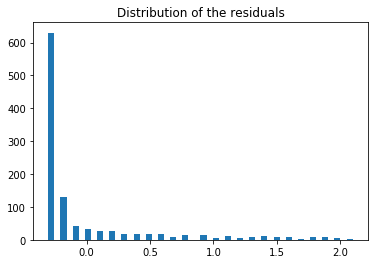

In [ ]:
clf_1 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

print(clf_1.fit(nn_x_train, nn_y_train))
print('Score =', clf_1.score(nn_x_test, nn_y_test))
nn_y_pred = clf_1.predict(nn_x_test)
plt.title("Distribution of the residuals")
plt.hist(nn_y_test - nn_y_pred, 50)
# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(nn_y_test, nn_y_pred))

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(8, 4), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Score = 0.3003298413497473
MAD = 0.3257233377116939


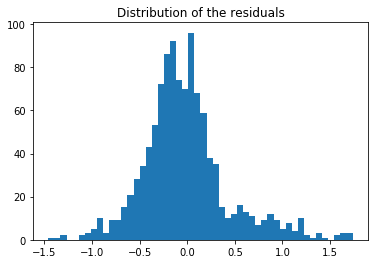

In [ ]:
clf_2 = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 4), random_state=1, max_iter=20000, early_stopping = True)

print(clf_2.fit(nn_x_train, nn_y_train))
print('Score =', clf_2.score(nn_x_test, nn_y_test))
nn_y_pred = clf_2.predict(nn_x_test)
plt.title("Distribution of the residuals")
plt.hist(nn_y_test - nn_y_pred, 50)
# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(nn_y_test, nn_y_pred))

MLPRegressor(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(9, 6), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Score = 0.37895836758363133
MAD = 0.2964532226137646


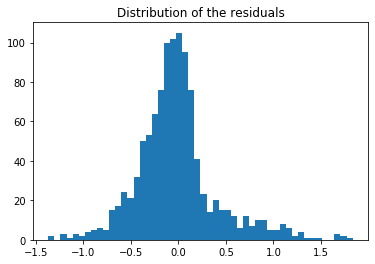

In [ ]:
clf_3 = MLPRegressor(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(9, 6), random_state=1, max_iter=20000, early_stopping = True)

print(clf_3.fit(nn_x_train, nn_y_train))
print('Score =', clf_3.score(nn_x_test, nn_y_test))
nn_y_pred = clf_3.predict(nn_x_test)
plt.title("Distribution of the residuals")
plt.hist(nn_y_test - nn_y_pred, 50)
# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(nn_y_test, nn_y_pred))

In [ ]:
score_opt = 0
mad_opt = 100
mad_at_opt_score = 100
score_at_opt_mad = 0
score_i, score_j = 0, 0
mad_i, mad_j = 0, 0
max_i = 10
max_j = 10
for i in range(1, max_i):
    for j in range(1, max_j):
        clf_itr = MLPRegressor(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(i, j), random_state=1, max_iter=20000, early_stopping = True)
#         print(clf_itr.fit(nn_x_train, nn_y_train))
#         print('Score =', clf_itr.score(nn_x_test, nn_y_test))
        clf_itr.fit(nn_x_train, nn_y_train)
        score_itr = clf_itr.score(nn_x_test, nn_y_test)
        itr_y_pred = clf_itr.predict(nn_x_test)
        mad_itr = mean_absolute_error(nn_y_test, itr_y_pred)
        if score_itr > score_opt:
            score_i, score_j = i, j
            score_opt = score_itr
            mad_at_opt_score = mad_itr
        if mad_itr < mad_opt:
            mad_i, mad_j = i, j
            mad_opt = mad_itr
            score_at_opt_mad = score_itr

In [ ]:
print("Optimal score =", score_opt)
print("MAD at optimal score =", mad_at_opt_score)
print("Optimal score layer sizes =", score_i, score_j)
print("Optimal MAD =", mad_opt)
print("Score at optimal MAD =", score_at_opt_mad)
print("Optimal MAD layer sizes =", mad_i, mad_j)

Optimal score = 0.37895836758363133
MAD at optimal score = 0.2964532226137646
Optimal score layer sizes = 9 6
Optimal MAD = 0.29429661761107184
Score at optimal MAD = 0.37244655870783905
Optimal MAD layer sizes = 6 7


In [ ]:
# Choosing the optimal classifier and training on entire training data

clf_opt = MLPRegressor(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(score_i, score_j), random_state=1, max_iter=20000, early_stopping = True)
clf_opt.fit(nn_x, nn_y)

MLPRegressor(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(9, 6), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

### Simulate the forecasting

The `weather_test.csv` file contains the weather data that was held out from `weather_train.csv` used for training the solar panel output predictor. This data simulates the weather forcasts and is used for evaluating how your model would perform if it was deployed.

In [ ]:
weather_test = pd.read_csv('./data/weather_test.csv')
weather_test.head()

,time,clouds,temperature,humidity,wind direction,wind speed,visibility,air pressure,year
0,2017-01-25T00:00:00Z,0,-0.3,91.0,OZO,1.0,3170.0,1031.2,2017
1,2017-01-25T00:10:00Z,0,-0.4,90.0,O,2.0,3160.0,1031.2,2017
2,2017-01-25T00:20:00Z,0,-0.4,90.0,OZO,2.0,2970.0,1031.1,2017
3,2017-01-25T00:30:00Z,0,-0.3,91.0,ZZO,2.0,2940.0,1031.0,2017
4,2017-01-25T00:40:00Z,0,-0.3,90.0,ZO,1.0,2980.0,1031.0,2017


Provide the predictions for the hourly solar panel output for the given weather forecasts, i.e. populate the `production` column in the following data frame:

In [ ]:
prediction = weather_test.copy()
times = pd.to_datetime(prediction["time"])
prediction['month'] = times.dt.month
prediction['day'] = times.dt.dayofyear
prediction['hour'] = times.dt.hour
prediction = prediction.drop(prediction[prediction['hour'] == 0].index)
prediction = prediction[['month', 'day', 'hour']]
prediction = prediction.drop_duplicates().reset_index(drop=True)
prediction['production'] = np.nan
prediction.head()

,month,day,hour,production
0,1,25,1,NaN
1,1,25,2,NaN
2,1,25,3,NaN
3,1,25,4,NaN
4,1,25,5,NaN


**Important:** your model will be evaluated on the held out test set. It is therefore safe to train your *final* model on the entire data set that was provided (rather than the X_train, y_train subsets from the train/test split above), to captures all of the information that is available to you.

### Question 14

Fill in the `'production'` column in the prediction data frame with your predictions (do not reorder the rows). Assign the values from the `'production`' column as a Python list to the variable `forecast`.

In [ ]:
q14_prediction = prediction.copy()
q14_weather = weather_test.copy()
print(q14_prediction)
print(q14_weather)

     month  day  hour  production
0        1   25     1         NaN
1        1   25     2         NaN
2        1   25     3         NaN
3        1   25     4         NaN
4        1   25     5         NaN
..     ...  ...   ...         ...
800      5  151    21         NaN
801      5  151    22         NaN
802      5  151    23         NaN
803      4  116     1         NaN
804      4  116     2         NaN

[805 rows x 4 columns]
                      time  clouds  temperature  humidity wind direction  \
0     2017-01-25T00:00:00Z       0         -0.3      91.0            OZO   
1     2017-01-25T00:10:00Z       0         -0.4      90.0              O   
2     2017-01-25T00:20:00Z       0         -0.4      90.0            OZO   
3     2017-01-25T00:30:00Z       0         -0.3      91.0            ZZO   
4     2017-01-25T00:40:00Z       0         -0.3      90.0             ZO   
...                    ...     ...          ...       ...            ...   
9989  2018-05-31T23:10:00Z       2  

In [ ]:
q14_times = pd.to_datetime(q14_weather["time"])
q14_weather_modified = q14_weather.groupby([q14_times.dt.month, q14_times.dt.dayofyear, q14_times.dt.hour])["clouds", "air pressure", "visibility", "temperature", "humidity", "wind speed"].agg(np.mean)
q14_weather_modified.index.names = ["month", "day", "hour"]
# print(q14_weather_modified)
q14_weather_modified = q14_weather_modified.reset_index()
q14_weather_modified = q14_weather_modified.drop(q14_weather_modified[q14_weather_modified['hour'] == 0].index)
q14_weather_modified = q14_weather_modified.reset_index()

# ws_data = pd.merge(energy, ws_weather).dropna().reset_index(drop=True)
# print(q14_weather_modified)
q14_weather_modified = q14_weather_modified[['month', 'day', 'hour', "clouds", "air pressure", "visibility", "temperature", "humidity", "wind speed"]]
q14_weather_modified = q14_weather_modified.drop_duplicates().reset_index(drop=True)
# print(q14_weather_modified)

In [ ]:
# print(q14_prediction)
q14_combined_data = pd.merge(q14_prediction, q14_weather_modified)
# print(q14_combined_data)

In [ ]:
#// BEGIN_TODO [Q14]
q14_x = q14_combined_data[["day", "hour", "clouds", "air pressure", "visibility", "temperature", "humidity", "wind speed"]].values
q14_y_pred = clf_opt.predict(q14_x)
# print(q14_y_pred)
#// END_TODO [Q14]

In [ ]:
q14_combined_data['production'] = q14_y_pred
# performing modification to make negative values 0 
# print(q14_combined_data)
q14_combined_data.loc[q14_combined_data['production'] < 0, 'production'] = 0
# print(q14_combined_data)

In [ ]:
print(q14_prediction)
print(q14_combined_data['production'])
prediction['production'] = q14_combined_data['production']
print(prediction)

     month  day  hour  production
0        1   25     1         NaN
1        1   25     2         NaN
2        1   25     3         NaN
3        1   25     4         NaN
4        1   25     5         NaN
..     ...  ...   ...         ...
800      5  151    21         NaN
801      5  151    22         NaN
802      5  151    23         NaN
803      4  116     1         NaN
804      4  116     2         NaN

[805 rows x 4 columns]
0      0.182489
1      0.117034
2      0.071340
3      0.049974
4      0.051850
         ...   
800    0.063256
801    0.000000
802    0.000000
803    0.418710
804    0.395454
Name: production, Length: 805, dtype: float64
     month  day  hour  production
0        1   25     1    0.182489
1        1   25     2    0.117034
2        1   25     3    0.071340
3        1   25     4    0.049974
4        1   25     5    0.051850
..     ...  ...   ...         ...
800      5  151    21    0.063256
801      5  151    22    0.000000
802      5  151    23    0.000000
803   

In [ ]:
# print(prediction['production'].tolist())
forecast = prediction['production'].tolist()
# print(forecast)

For automating the evaluation of your predictions, call the evaluate function that is defined in the `evaluate.py` script (do not edit the code lines below!):

In [ ]:
from evaluate_stub import *
evaluate(prediction)

'This is a stub for the evaluation function. The real implementation will compare your predictions with the held out production measurements.'

As a sanity check, make sure that the `prediction` data frame contains a `production` column and 805 rows.

Your solution will be evaluated based on the mean absolute error metric.

### Reliability

We often assume that the trained model will operate on data from the same distribution as the data it was trained on (see Chapter 1 of the book "Dataset Shift in Machine Learning"). However, sometimes these assumptions are not true.

Using the model you trained for question 13, evaluate the model's performance on the data set provided below. It contains the weather, production and consumption data for the year 2019, preprocessed into a single .csv file.

In [ ]:
weather_energy = pd.read_csv('./data/weather_energy_2019.csv')
weather_energy.head()

,index,year,month,day,hour,production,consumption,clouds,temperature,humidity,wind speed,visibility,air pressure
0,35,2019,1,2,10,0.3,3.215163,0.0,35.768333,76.500000,4.500000,20050.000000,1037.650000
1,36,2019,1,2,11,0.3,3.982344,0.0,35.621667,75.833333,4.666667,20283.333333,1037.550000
2,37,2019,1,2,12,0.3,3.550910,0.0,35.383333,72.333333,5.000000,19133.333333,1037.433333
3,38,2019,1,2,13,0.2,3.372008,0.0,35.530000,73.833333,4.833333,15700.000000,1037.616667
4,39,2019,1,2,14,0.2,3.838542,0.5,35.713333,71.500000,3.833333,16350.000000,1037.883333


In [ ]:
# TODO: Evaluate the model from previous question on the new data
q15_weather_energy = weather_energy.copy()

index             int64
year              int64
month             int64
day               int64
hour              int64
production      float64
consumption     float64
clouds          float64
temperature     float64
humidity        float64
wind speed      float64
visibility      float64
air pressure    float64
dtype: object
Score = -28.234748221597762
MAD = 0.788033185818855


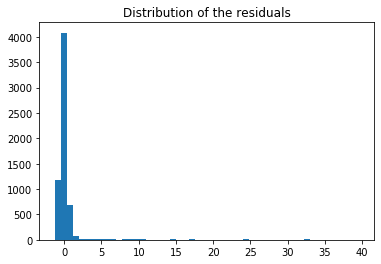

In [ ]:
print(q15_weather_energy.dtypes)
q15_weather_energy = q15_weather_energy[["day", "hour", "clouds", "air pressure", "visibility", "temperature", "humidity", "wind speed", "production"]]
# print('---')
q15_x = q15_weather_energy[["day", "hour", "clouds", "air pressure", "visibility", "temperature", "humidity", "wind speed"]].values
q15_y = q15_weather_energy["production"].values
print('Score =', clf_opt.score(q15_x, q15_y))
q15_y_pred = clf_opt.predict(q15_x)
plt.title("Distribution of the residuals")
plt.hist(q15_y - q15_y_pred, 50)
# y_pred = model.predict(X_test)
print('MAD =', mean_absolute_error(q15_y, q15_y_pred))

### Question 15

Investigate and then explain in at most 100 words in `question_change` what you think is responsible for the change in your model's performance.

In [ ]:
# TODO: Investigate changes
print("Temperature stats")
print(q15_weather_energy['temperature'].max())
print(q15_weather_energy['temperature'].min())
print(q15_weather_energy['temperature'].mean())
print(q15_weather_energy['temperature'].std())

print("Clouds stats")
print(q15_weather_energy['clouds'].mean())
print(q15_weather_energy['clouds'].std())

print("Visibility stats")
print(q15_weather_energy['visibility'].min())
print(q15_weather_energy['visibility'].max())
print(q15_weather_energy['visibility'].mean())
print(q15_weather_energy['visibility'].std())

print("Humidity stats")
print(q15_weather_energy['humidity'].min())
print(q15_weather_energy['humidity'].max())
print(q15_weather_energy['humidity'].mean())
print(q15_weather_energy['humidity'].std())

Temperature stats
52.08500000000002
0.0
28.787447879858664
7.7518760398556115
Clouds stats
1.0277465467394795
1.1769893945661272
Visibility stats
64.5
49900.0
26307.32693543206
13776.012869924449
Humidity stats
17.833333333333332
98.83333333333331
73.68496894742478
18.52405670466883


In [ ]:
#// BEGIN_TODO [Q15]
question_change = '''
The date ranges are pretty similar. Tthe variation could be due to long-term seasonal changes, solar panel 
installation degradation, normal signal noise. Also, certain data ranges were also missing.
Temperature increased to a maximum of 52 degrees with an average of 28 degrees. Previous years had a maximum of 30 degrees 
and a minimum of -8 degrees. Global warming might be causing a significant effect over all the weather conditions.
'''
#// END_TODO [Q15]

### Question 16

To make your model robust to these kind of changes, you may want to re-train it on more appropriate data. Using all the data you have been provided so far, compose more suitable training and test data sets, and assign them to `new_training_data` and `new_test_data`, respectively.

In [ ]:
#// BEGIN_TODO [Q16]
# q16_clf_opt = MLPRegressor(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(score_i, score_j), random_state=1, max_iter=20000, early_stopping = True)
# clf_opt.fit(nn_x, nn_y)
q16_previous_data_x = nn_x.copy()
# print(nn_x.shape)
q16_previous_data_y = nn_y.copy()
# print(nn_y.shape)
q16_2019_data_x = q15_x.copy()
# print(q16_2019_data_x.shape)
q16_2019_data_y = q15_y.copy()
# print(q16_2019_data_y.shape)
q16_data_x = np.concatenate((q16_previous_data_x, q16_2019_data_x))
q16_data_y = np.append(q16_previous_data_y, q16_2019_data_y)
# print(q16_data_x.shape)
# print(q16_data_y.shape)
#// END_TODO [Q16]

(5423, 8)
(5423,)
(6226, 8)
(6226,)
(11649, 8)
(11649,)


In [ ]:
q16_x_train, q16_x_test, q16_y_train, q16_y_test = train_test_split(q16_data_x, q16_data_y, test_size=0.2, random_state=42)
new_training_data = [q16_x_train, q16_y_train]
new_test_data = [q16_x_test, q16_y_test]

### Predicting consumption

Besides solar production, we are also interested in predicting energy consumption. Being able to accurately predict the power bill may save us from any surprises in the future. 

### Question 17

Consumption may depend on other factors than production, so we may need to reconsider the features we chose in question 12. Considering the new training target, which two features from question 12 are most promising for the prediction of energy consumption? Assign them to `question_consumption_features`.

In [ ]:
#// BEGIN_TODO [Q17]
#// END_TODO [Q17]

Train and evaluate your new model on the data in `data` (do not include the data from `weather_energy`) to predict the energy consumption.

In [ ]:
# TODO: Train a new model to predict energy consumption

### Question 18

As in question 15, check this new model's performance when predicting the energy consumption for the data in `weather_energy`. Is there a shift taking place in the data underlying the model? If so, what kind of shift do you think it is? Assign your answer to `question_consumption_shift`.

1. Sample covariate shift
2. Source component shift
3. No shift

In [ ]:
#// BEGIN_TODO [Q18]
#// END_TODO [Q18]

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these Exercises?

Assign a number to `feedback_time`.

In [ ]:
#// BEGIN_TODO [Feedback_1]
feedback_time = 80
#// END_TODO [Feedback_1]

### How difficult did you find these Exercises?

Assign an integer to `feedback_difficulty`, on a scale 1 - 10, with 1 being very easy.

In [ ]:
#// BEGIN_TODO [Feedback_2]
feedback_difficulty = 7
#// END_TODO [Feedback_2]

### Did you take the course Foundations of Data Mining?

Assign a boolean value to `feedback_foundations` (True or False).

In [ ]:
#// BEGIN_TODO [Feedback_3]
feedback_foundations = True
#// END_TODO [Feedback_3]

### Did you do any other Machine Learning-related coursework (university/workshop/online/etc)

Assign an answer to `feedback_other`, describing any other coursework done.

In [ ]:
#// BEGIN_TODO [Feedback_4]
feedback_other = "Recommender Systems"
#// END_TODO [Feedback_4]

### (Optional) What did you like?

Assign a string to `feedback_like`.

In [ ]:
#// BEGIN_TODO [Feedback_5]
#// END_TODO [Feedback_5]

### (Optional) What can be improved?

Assign a string to `feedback_improve`.

In [ ]:
#// BEGIN_TODO [Feedback_6]
#// END_TODO [Feedback_6]